<h2>Project of regression problem</h2>

Problem description:

Goal:

Dataset: This dataset contains medical insurance cost information for 1338 individuals. It includes demographic and health-related variables such as age, sex, BMI, number of children, smoking status, and residential region in the US. The target variable is charges, which represents the medical insurance cost billed to the individual.

In [40]:
import pandas as pd, matplotlib.pyplot as plt, numpy as np, seaborn as sb
import warnings, lru, numba
warnings.filterwarnings('ignore')

<h2>Data preparation</h2>
In this stage we conduct data preparation to ensure the missing data, wrong data types and basic feature engineering are in place.

In [41]:
regression_dataset = pd.read_csv('./data/medical insurance/insurance.csv')

In [85]:
regression_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   int64  
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   int64  
 5   region    1338 non-null   int64  
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(5)
memory usage: 73.3 KB


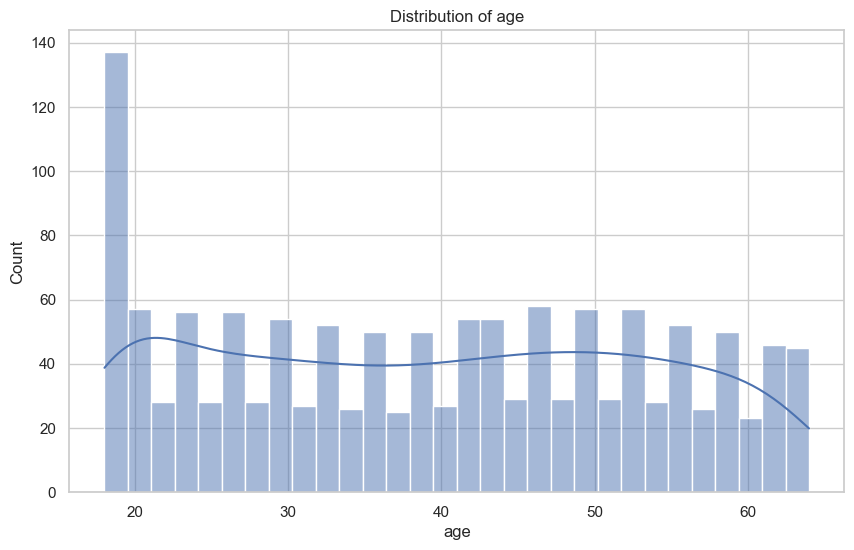

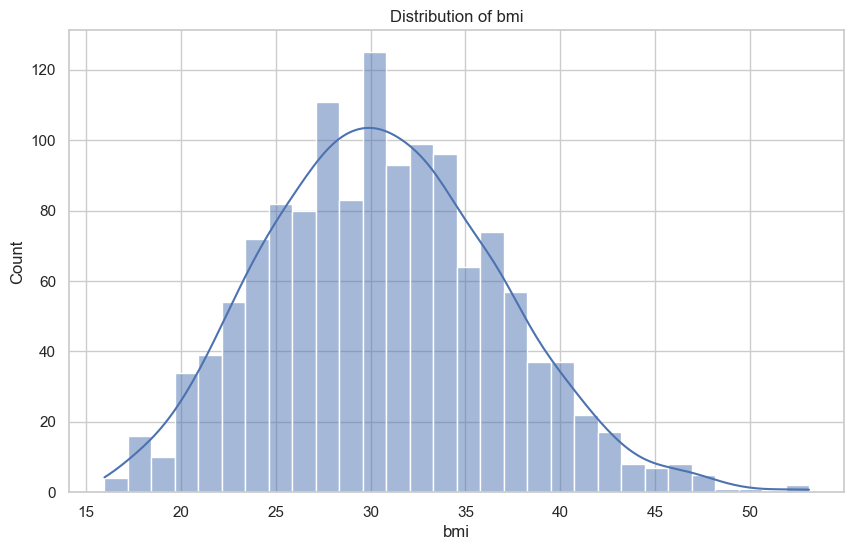

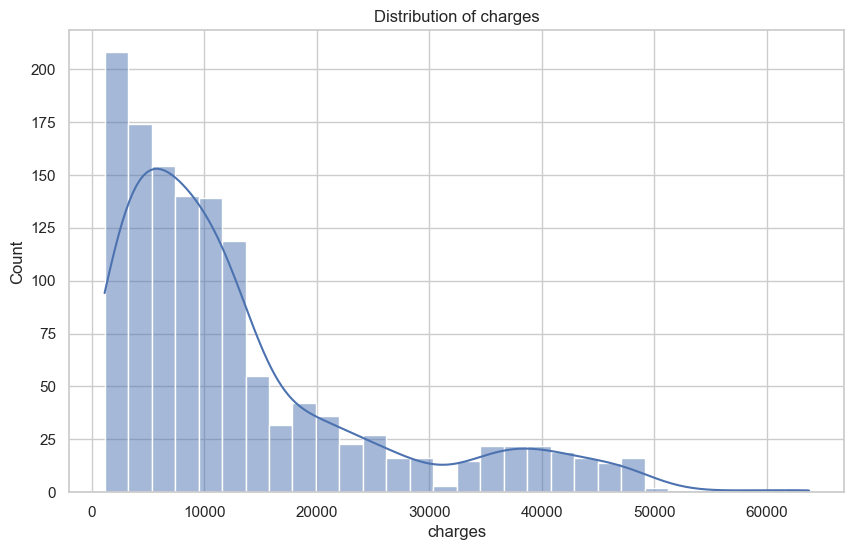

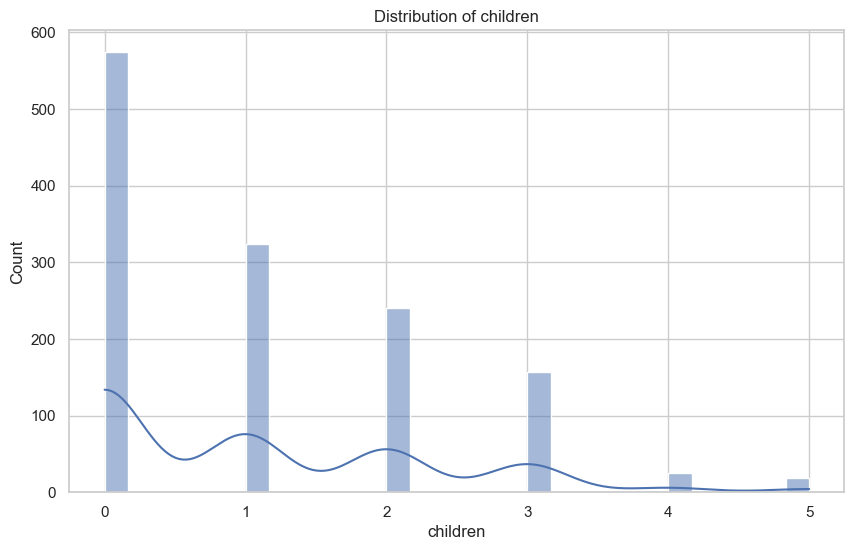

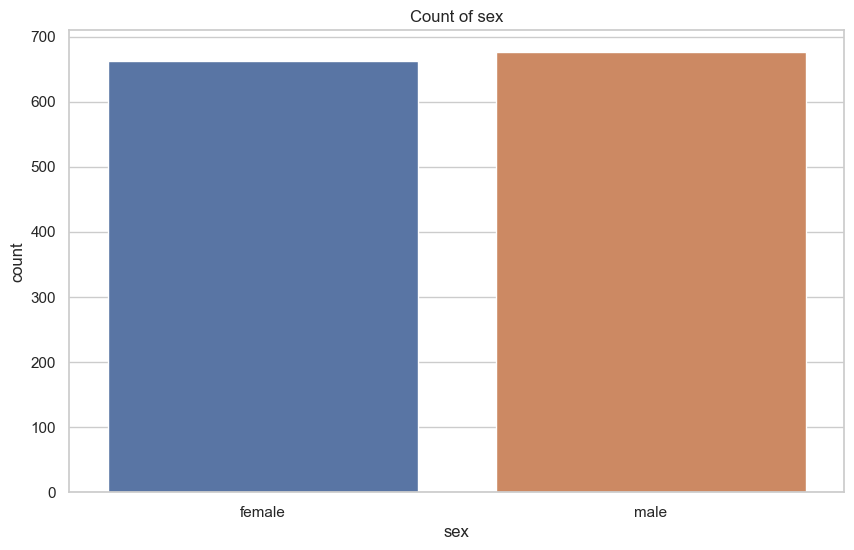

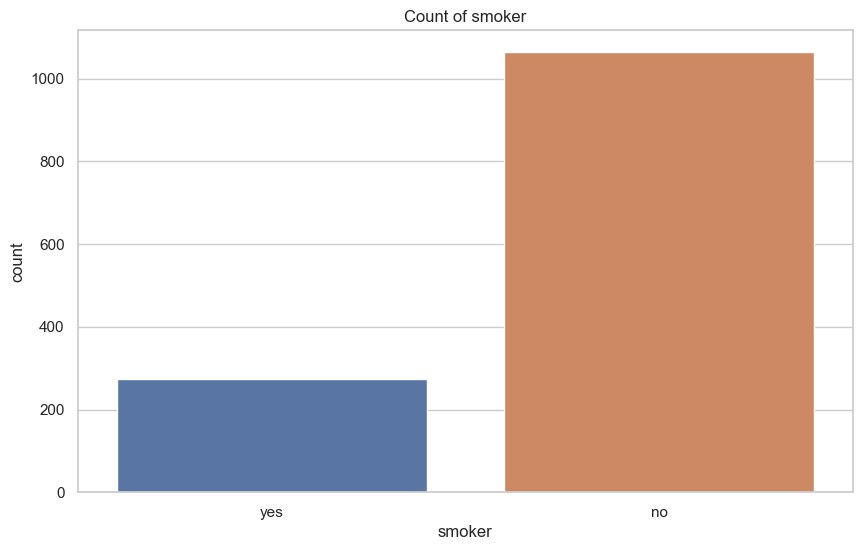

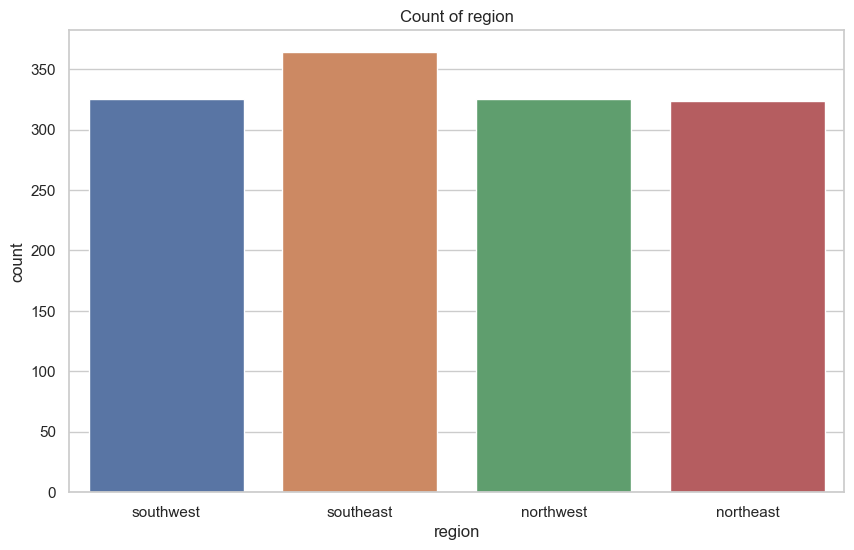

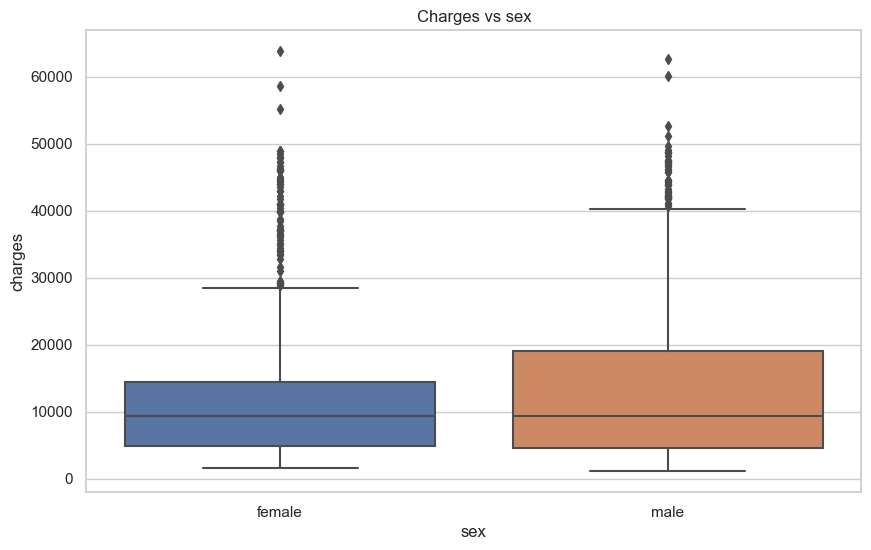

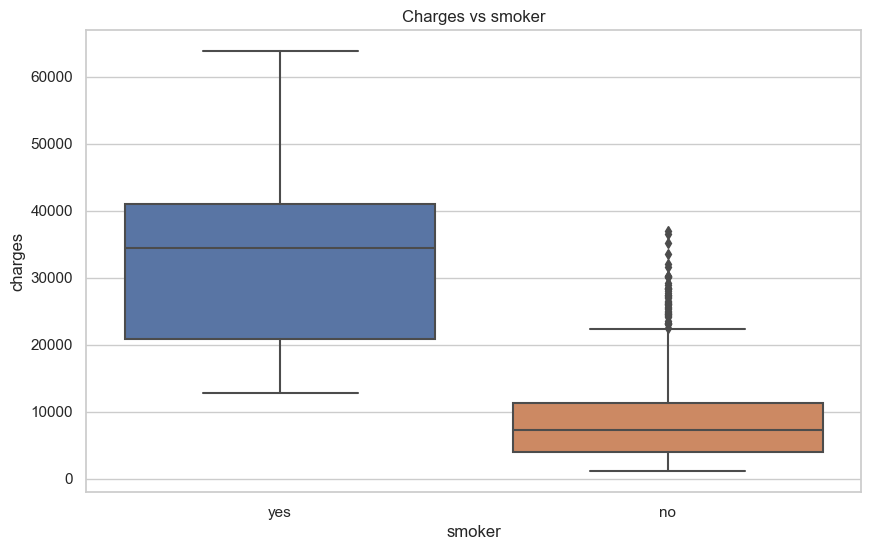

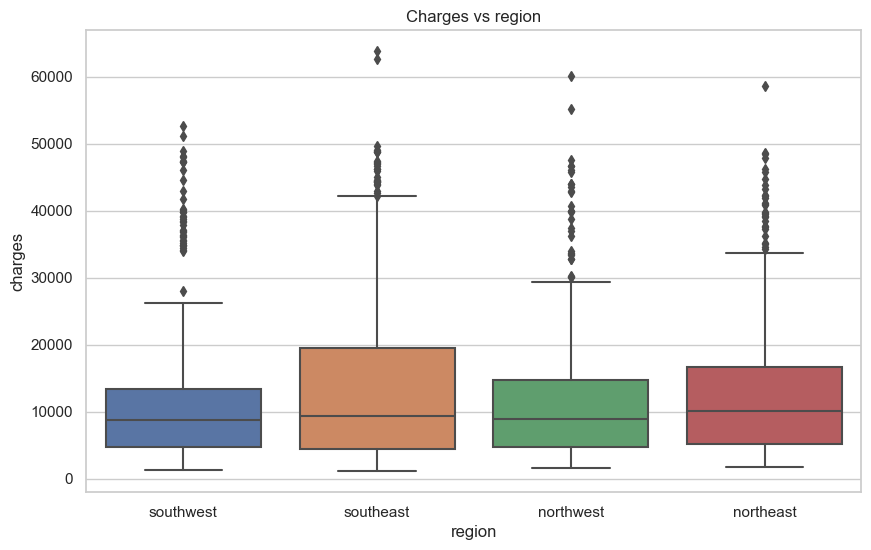

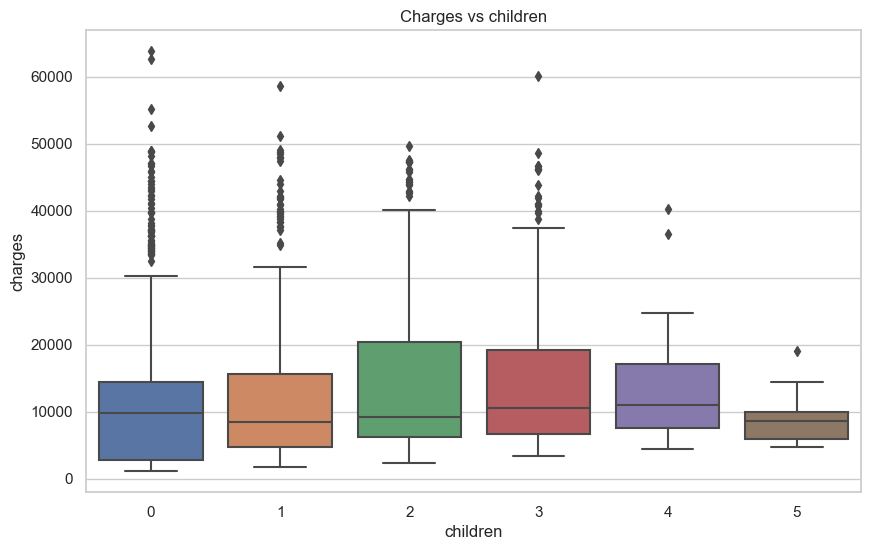

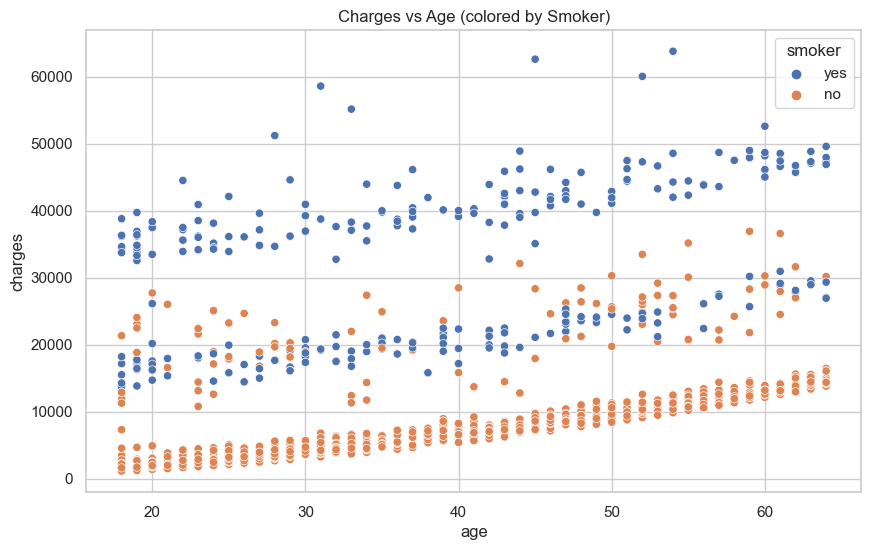

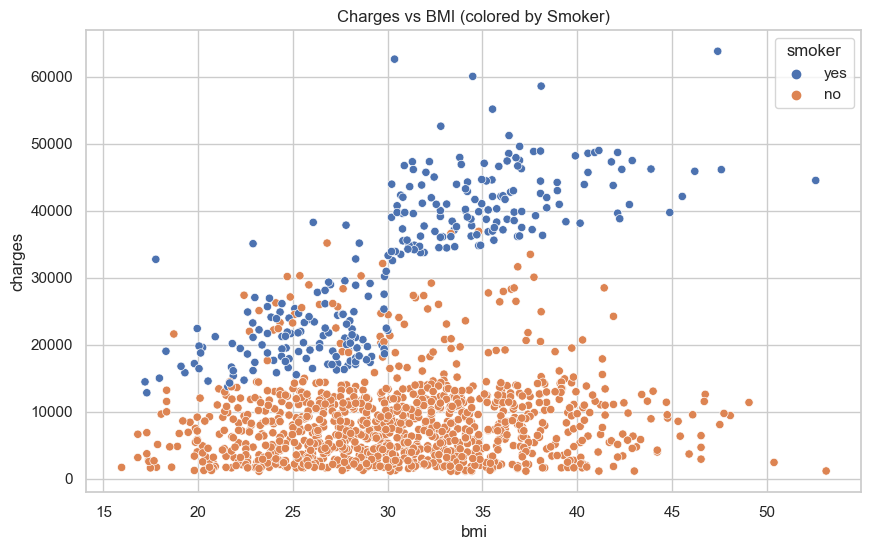

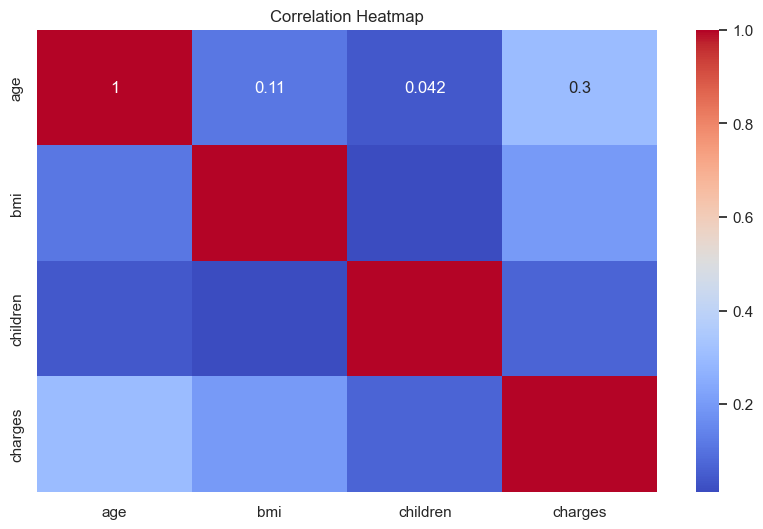

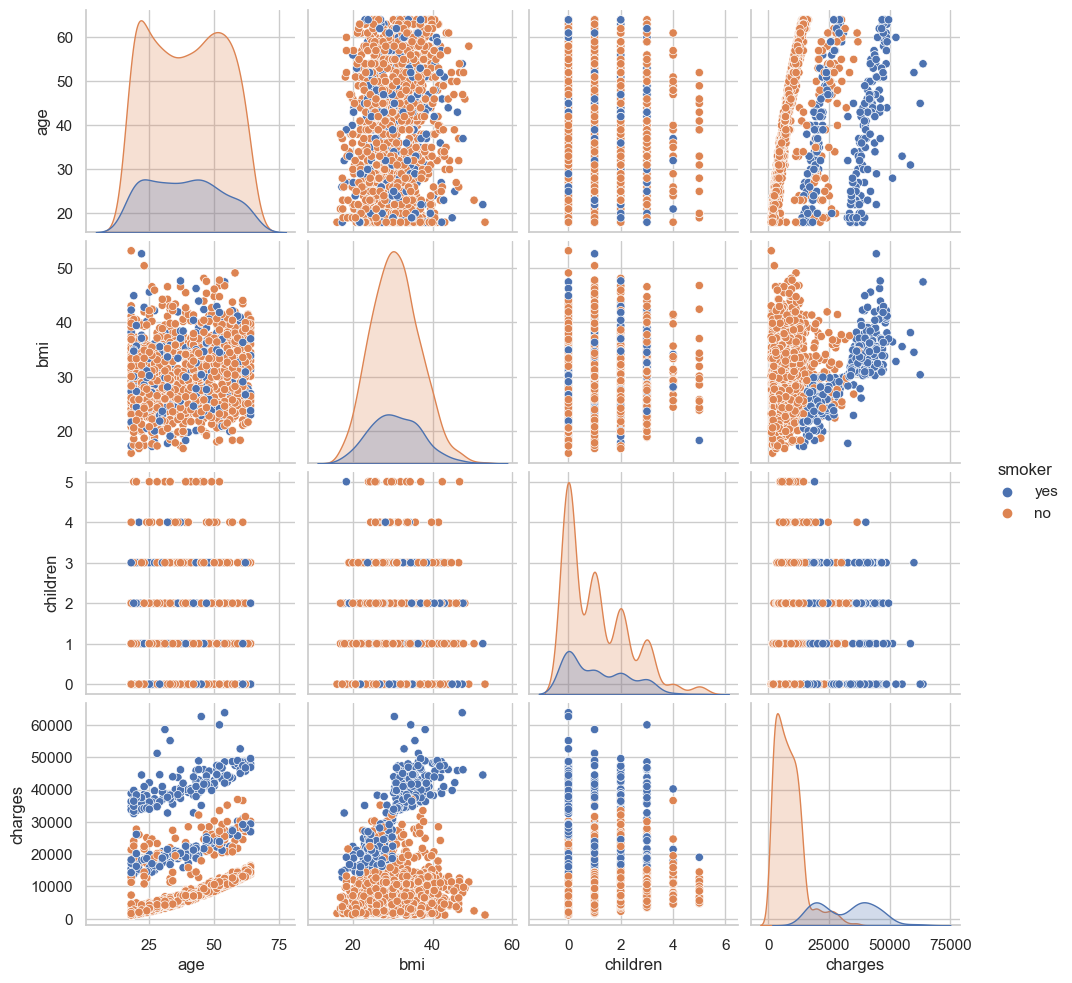

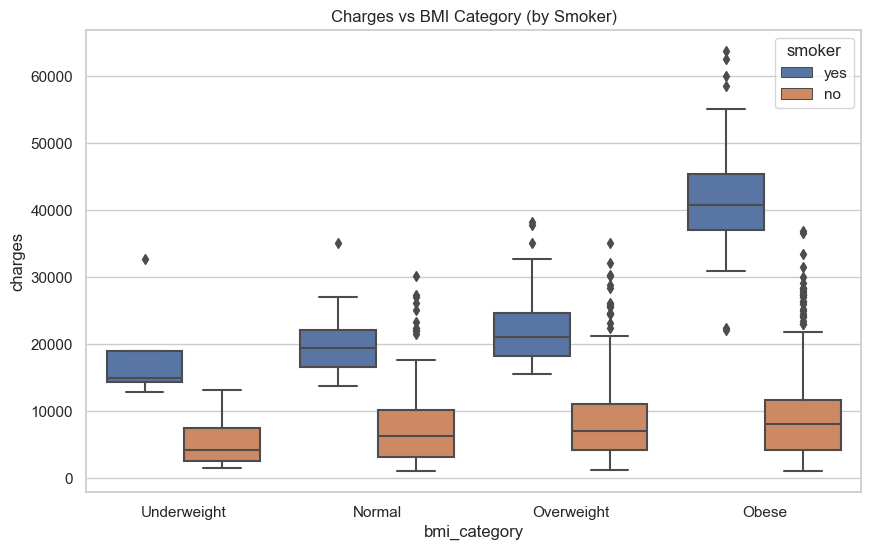

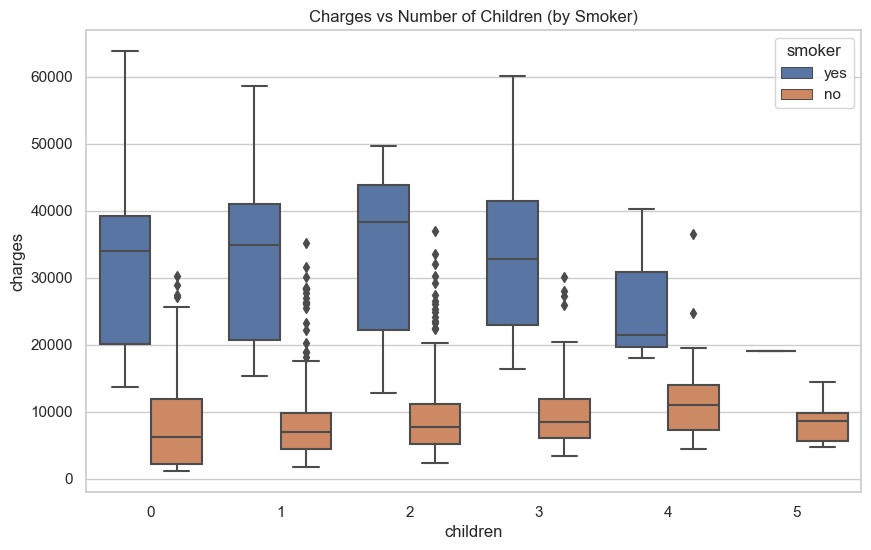

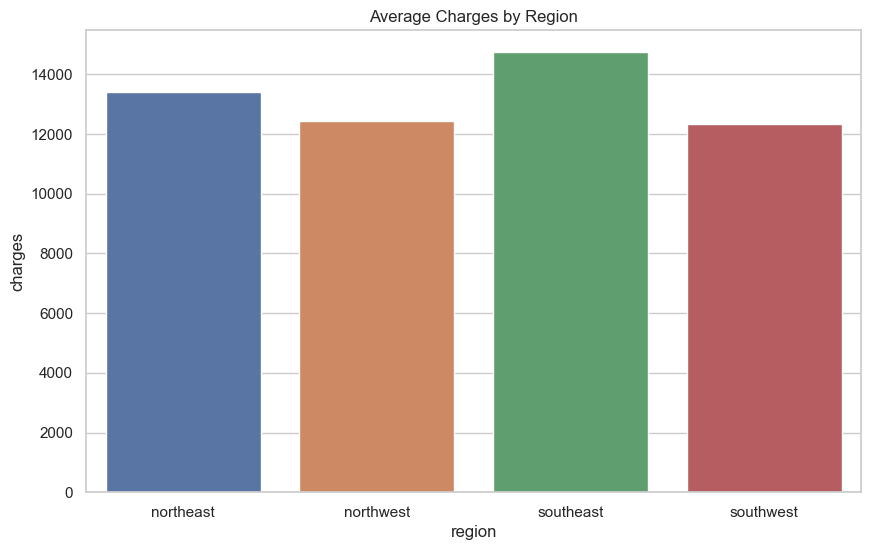

In [42]:
regression_dataset2 = pd.read_csv('./data/medical insurance/insurance.csv')

sb.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

numeric_cols = ['age', 'bmi', 'charges', 'children']
for col in numeric_cols:
    plt.figure()
    sb.histplot(regression_dataset2[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

categorical_cols = ['sex', 'smoker', 'region']
for col in categorical_cols:
    plt.figure()
    sb.countplot(x=col, data=regression_dataset2)
    plt.title(f'Count of {col}')
    plt.show()

for col in ['sex', 'smoker', 'region', 'children']:
    plt.figure()
    sb.boxplot(x=col, y='charges', data=regression_dataset2)
    plt.title(f'Charges vs {col}')
    plt.show()

plt.figure()
sb.scatterplot(x='age', y='charges', hue='smoker', data=regression_dataset2)
plt.title('Charges vs Age (colored by Smoker)')
plt.show()

plt.figure()
sb.scatterplot(x='bmi', y='charges', hue='smoker', data=regression_dataset2)
plt.title('Charges vs BMI (colored by Smoker)')
plt.show()

plt.figure()
sb.heatmap(regression_dataset2[['age','bmi','children','charges']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

sb.pairplot(regression_dataset2[['age','bmi','children','charges','smoker']], hue='smoker')
plt.show()


bins = [0, 18.5, 24.9, 29.9, 100]
labels = ['Underweight', 'Normal', 'Overweight', 'Obese']
regression_dataset2['bmi_category'] = pd.cut(regression_dataset2['bmi'], bins=bins, labels=labels)

plt.figure()
sb.boxplot(x='bmi_category', y='charges', hue='smoker', data=regression_dataset2)
plt.title('Charges vs BMI Category (by Smoker)')
plt.show()

plt.figure()
sb.boxplot(x='children', y='charges', hue='smoker', data=regression_dataset2)
plt.title('Charges vs Number of Children (by Smoker)')
plt.show()

region_avg = regression_dataset2.groupby('region')['charges'].mean().reset_index()
plt.figure()
sb.barplot(x='region', y='charges', data=region_avg)
plt.title('Average Charges by Region')
plt.show()


In [43]:
regression_dataset['sex'] = regression_dataset['sex'].map({'male': 0,'female': 1})
regression_dataset['smoker'] = regression_dataset['smoker'].map({'no': 0,'yes': 1})
regression_dataset['region'] = regression_dataset['region'].map({'southwest': 0,'northwest': 1,'northeast': 2,'southeast': 3})
print(regression_dataset['region'].unique())
print(regression_dataset.isna().sum())

[0 3 1 2]
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


In [44]:
print(regression_dataset.head())
print(regression_dataset.dtypes)

   age  sex     bmi  children  smoker  region      charges
0   19    1  27.900         0       1       0  16884.92400
1   18    0  33.770         1       0       3   1725.55230
2   28    0  33.000         3       0       3   4449.46200
3   33    0  22.705         0       0       1  21984.47061
4   32    0  28.880         0       0       1   3866.85520
age           int64
sex           int64
bmi         float64
children      int64
smoker        int64
region        int64
charges     float64
dtype: object


In [45]:
y = regression_dataset['charges']
X = regression_dataset.drop('charges', axis=1)

In [46]:
regression_dataset.describe()

,age,sex,bmi,children,smoker,region,charges
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,0.494768,30.663397,1.094918,0.204783,1.543348,13270.422265
std,14.049960,0.500160,6.098187,1.205493,0.403694,1.130917,12110.011237
min,18.000000,0.000000,15.960000,0.000000,0.000000,0.000000,1121.873900
25%,27.000000,0.000000,26.296250,0.000000,0.000000,1.000000,4740.287150
50%,39.000000,0.000000,30.400000,1.000000,0.000000,2.000000,9382.033000
75%,51.000000,1.000000,34.693750,2.000000,0.000000,3.000000,16639.912515
max,64.000000,1.000000,53.130000,5.000000,1.000000,3.000000,63770.428010


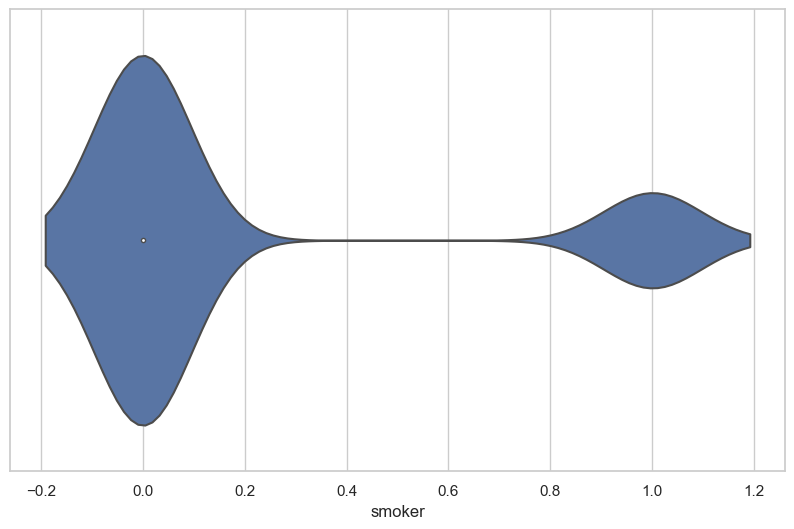

In [47]:
ax1 = sb.violinplot(x='smoker', data=regression_dataset)

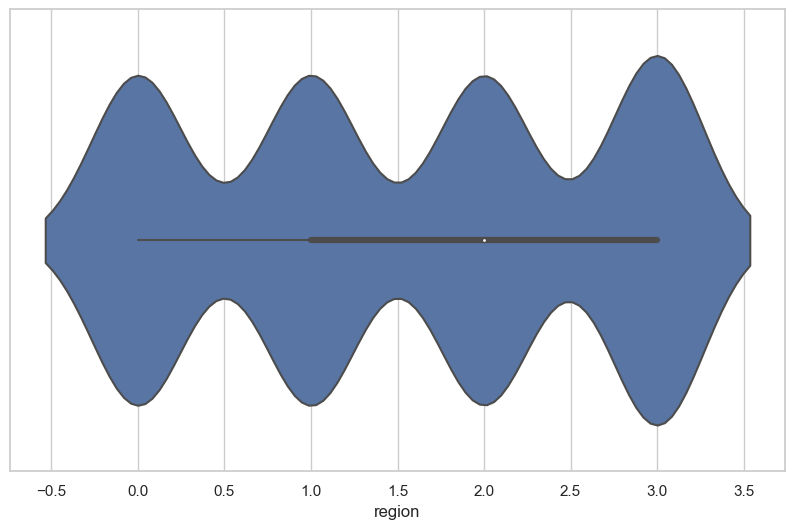

In [48]:
ax1 = sb.violinplot(x='region', data=regression_dataset)

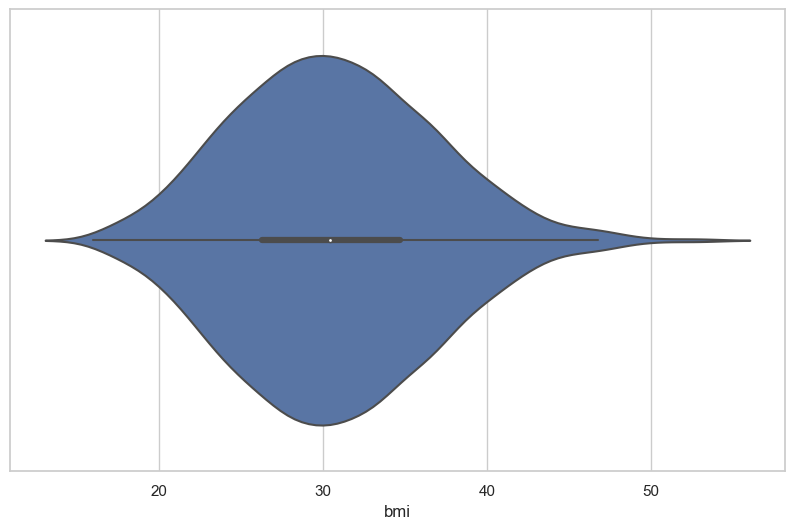

In [49]:
ax1 = sb.violinplot(x='bmi', data=regression_dataset)

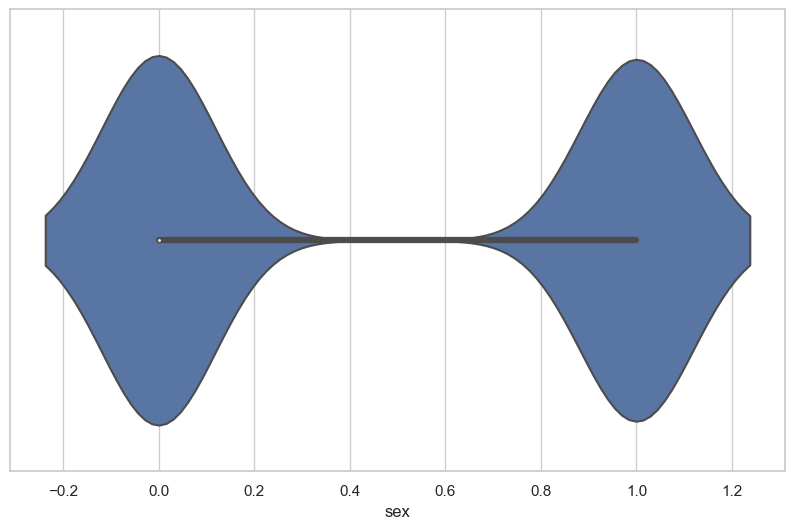

In [50]:
ax1 = sb.violinplot(x='sex', data=regression_dataset)

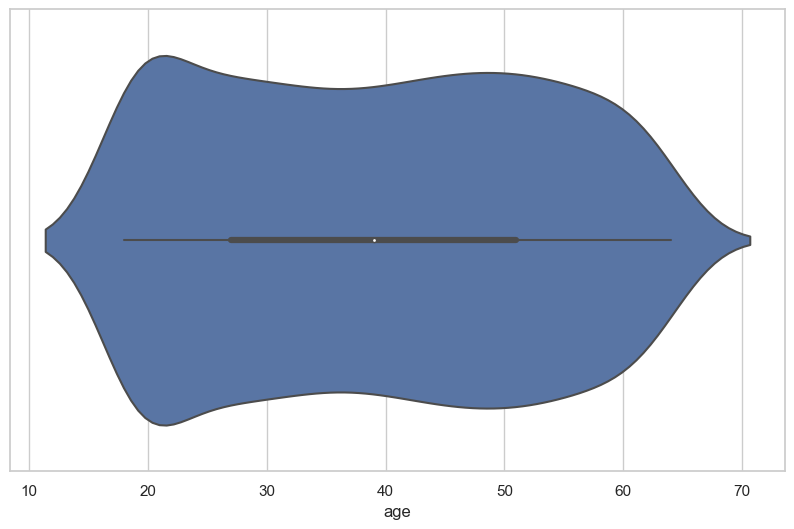

In [51]:
ax1 = sb.violinplot(x='age', data=regression_dataset)

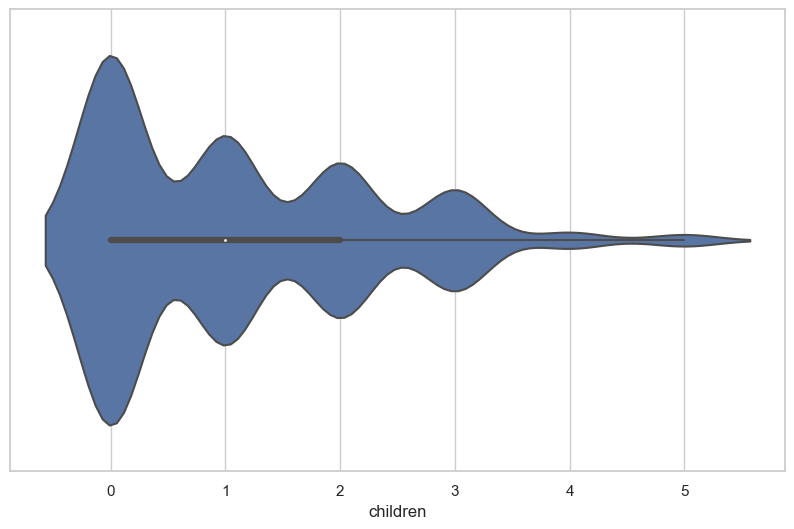

In [52]:
ax2 = sb.violinplot(x='children', data=regression_dataset)

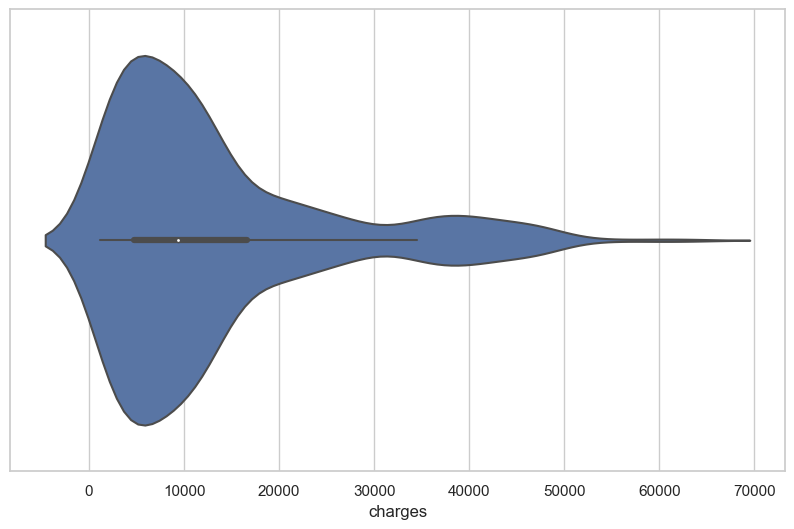

In [53]:
ax3 = sb.violinplot(x='charges', data=regression_dataset)

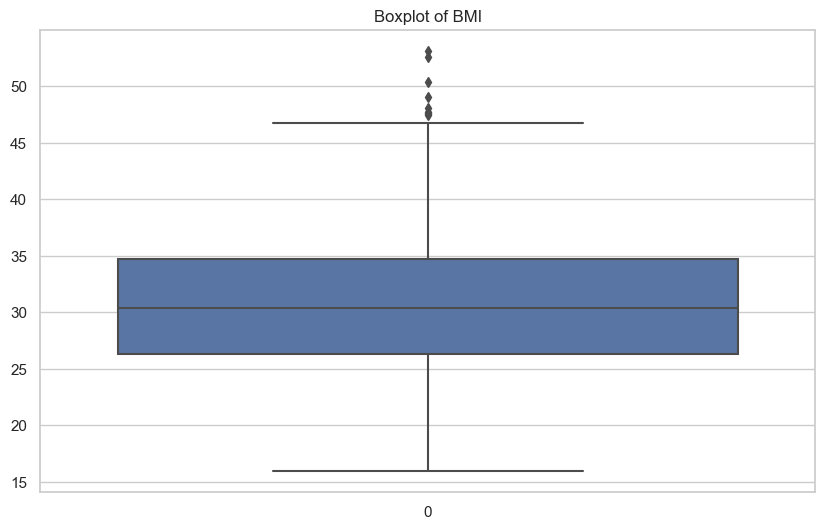

In [54]:
column_name = list(regression_dataset)
df_diabetics = pd.DataFrame(regression_dataset, columns=column_name)

sb.boxplot(df_diabetics['bmi'])
plt.title('Boxplot of BMI')
plt.show()

In [55]:
corr = regression_dataset.corr()
corr.style.background_gradient(cmap='coolwarm')

,age,sex,bmi,children,smoker,region,charges
age,1.000000,0.020856,0.109272,0.042469,-0.025019,-0.012027,0.299008
sex,0.020856,1.000000,-0.046371,-0.017163,-0.076185,-0.014144,-0.057292
bmi,0.109272,-0.046371,1.000000,0.012759,0.003750,0.162590,0.198341
children,0.042469,-0.017163,0.012759,1.000000,0.007673,-0.035115,0.067998
smoker,-0.025019,-0.076185,0.003750,0.007673,1.000000,0.069008,0.787251
region,-0.012027,-0.014144,0.162590,-0.035115,0.069008,1.000000,0.077042
charges,0.299008,-0.057292,0.198341,0.067998,0.787251,0.077042,1.000000


<h2>Feature Engineering</h2>

In [56]:
regression_dataset.head()

,age,sex,bmi,children,smoker,region,charges
0,19,1,27.900,0,1,0,16884.92400
1,18,0,33.770,1,0,3,1725.55230
2,28,0,33.000,3,0,3,4449.46200
3,33,0,22.705,0,0,1,21984.47061
4,32,0,28.880,0,0,1,3866.85520


<h2>One hot encoding binary and nominal variables.</h2>

In [57]:
from sklearn.preprocessing import OneHotEncoder

df_pandas_encoded = pd.get_dummies(X, columns=['sex', 'region', 'smoker'], drop_first=True)
encoder = OneHotEncoder(sparse_output=False)

one_hot_encoded = encoder.fit_transform(X[['sex', 'region', 'smoker']])
one_hot_df = pd.DataFrame(one_hot_encoded, 
                          columns=encoder.get_feature_names_out(['sex', 'region', 'smoker']))

X = pd.concat([X.drop(['sex', 'region', 'smoker'], axis=1), one_hot_df], axis=1)

X.head()

,age,bmi,children,sex_0,sex_1,region_0,region_1,region_2,region_3,smoker_0,smoker_1
0,19,27.900,0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
1,18,33.770,1,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,28,33.000,3,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,33,22.705,0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,32,28.880,0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


<h3>Should we scale and/or normalize the data?</h3>
Not really. It may distort feature importances and make interpretability harder. Decision trees and ensemble methods built from them split data based on feature thresholds

<h3>Train test validation split</h3>

In [58]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                   test_size=0.30, 
                                   shuffle=True,
                                   random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test,
                                   test_size=0.50, 
                                   shuffle=True,
                                   random_state=42)

<h2>Model training - Decision Tree Regressor, XGBoost Regression, Ensemble Random Forest Regressor</h2>

In [59]:
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

<h2>Random Forest Model</h2>

In [60]:
tree_regressor = RandomForestRegressor(max_depth=4, random_state=42, bootstrap=True, oob_score=True)
tree_regressor.fit(X_train, y_train)

RandomForestRegressor(max_depth=4, oob_score=True, random_state=42)

In [61]:
from sklearn.model_selection import cross_val_score

y_pred = tree_regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Mean Absolute Percentage Error: {mape:.4f}")
print(f"R2 Error: {r2:.4f}")


Mean Squared Error: 21279751.8234
Mean Absolute Error: 2699.8135
Mean Absolute Percentage Error: 0.2949
R2 Error: 0.8597


In [62]:
import optuna
from functools import lru_cache
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import LeaveOneOut, KFold

In [63]:
def objective(trial):
    params ={
        'max_depth': trial.suggest_int("max_depth", 3, 32, log=True),
        'min_samples_split': trial.suggest_int("min_samples_split", 5, 10),
        'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.01, 0.5),
        'min_weight_fraction_leaf': trial.suggest_float('min_weight_fraction_leaf', 0.01, 0.50),
        'ccp_alpha': trial.suggest_float('ccp_alpha', 0.01, 0.99),
    }

    clf=RandomForestRegressor(**params, random_state=42, bootstrap=True, oob_score=True, n_jobs=8)
    clf.fit(X_train, y_train)

    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error')

    #pred = clf.predict(X_val)
    #mse = mean_squared_error(y_val, pred)
    return -scores.mean()

In [64]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

[I 2025-11-18 15:08:09,761] A new study created in memory with name: no-name-bc2c32e3-69ae-4a9c-9d19-dc6fce89449b
[I 2025-11-18 15:08:12,290] Trial 0 finished with value: 9152.374572124161 and parameters: {'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 0.2544908345850479, 'min_weight_fraction_leaf': 0.24897474095504998, 'ccp_alpha': 0.7409296627853666}. Best is trial 0 with value: 9152.374572124161.
[I 2025-11-18 15:08:14,597] Trial 1 finished with value: 9163.257101826119 and parameters: {'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 0.18623228253335603, 'min_weight_fraction_leaf': 0.2438848716305209, 'ccp_alpha': 0.10759354334388577}. Best is trial 0 with value: 9152.374572124161.
[I 2025-11-18 15:08:16,918] Trial 2 finished with value: 9156.641291379212 and parameters: {'max_depth': 32, 'min_samples_split': 8, 'min_samples_leaf': 0.23938598859455953, 'min_weight_fraction_leaf': 0.2616855137863459, 'ccp_alpha': 0.43423260426737353}. Best is trial 0 with val

In [65]:
print("Best random forest hyperparameters:", study.best_params)
print("Best random forest score:", study.best_value)

Best random forest hyperparameters: {'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 0.011189013109939125, 'min_weight_fraction_leaf': 0.012354212051069347, 'ccp_alpha': 0.11662141690706046}
Best random forest score: 2621.0236742911975


In [66]:
optuna.visualization.plot_optimization_history(study)
optuna.visualization.plot_param_importances(study)

In [67]:
best_random_model = RandomForestRegressor(**study.best_params, random_state=42)

best_random_model.fit(X_train, y_train)

def RFtest(best_model):
    test_pred = best_random_model.predict(X_test)
    test_mse = mean_squared_error(y_test, test_pred)
    test_mae = mean_absolute_error(y_test, test_pred)
    test_r2 = r2_score(y_test, test_pred)
    test_mape = mean_absolute_percentage_error(y_test, test_pred)

    print("Test MSE:", test_mse)
    print("Test MAE:", test_mae)
    print("Test R2:", test_r2)
    print("Test MAPE:", test_mape)

    return [test_mse, test_mae, test_mape, test_r2]

RFtest(best_model=best_random_model)

Test MSE: 20305168.384841282
Test MAE: 2620.422154666396
Test R2: 0.8661043285480746
Test MAPE: 0.281229459372244


[20305168.384841282, 2620.422154666396, 0.281229459372244, 0.8661043285480746]

In [68]:
feature_names = [f"feature {i}" for i in range(X.shape[1])]
std = np.std([tree.feature_importances_ for tree in best_random_model.estimators_], axis=0)


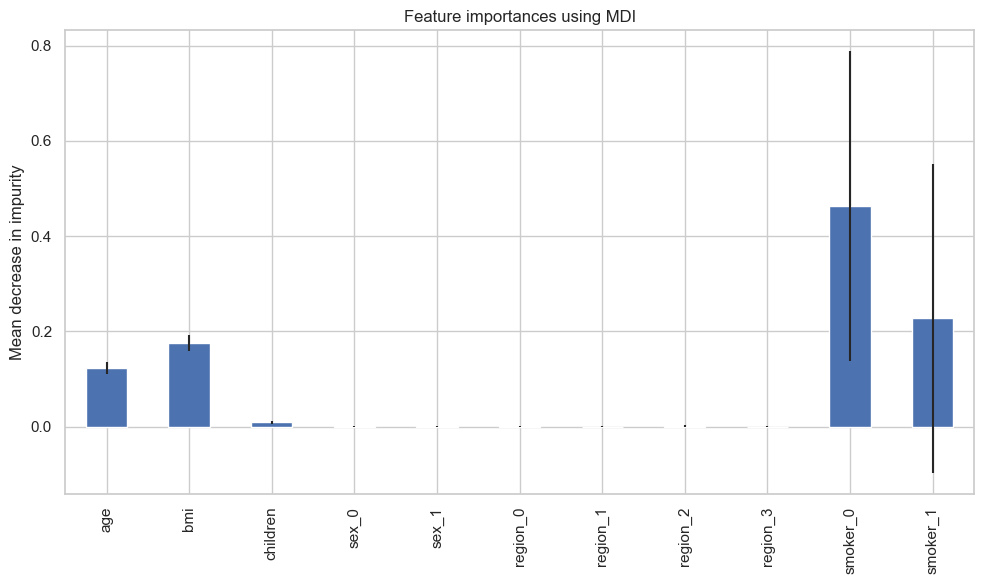

In [69]:
import pandas as pd
forest_importances = pd.Series(best_random_model.feature_importances_, index=list(X))

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

<h2>Training Random Forest on the best parameters</h2>

In [70]:
best_random_model = RandomForestRegressor(**study.best_params, random_state=42)

best_random_model.fit(X_train, y_train)

test_pred = best_random_model.predict(X_test)
test_mse = mean_squared_error(y_test, test_pred)
print("Test MSE:", test_mse)

Test MSE: 20305168.384841282


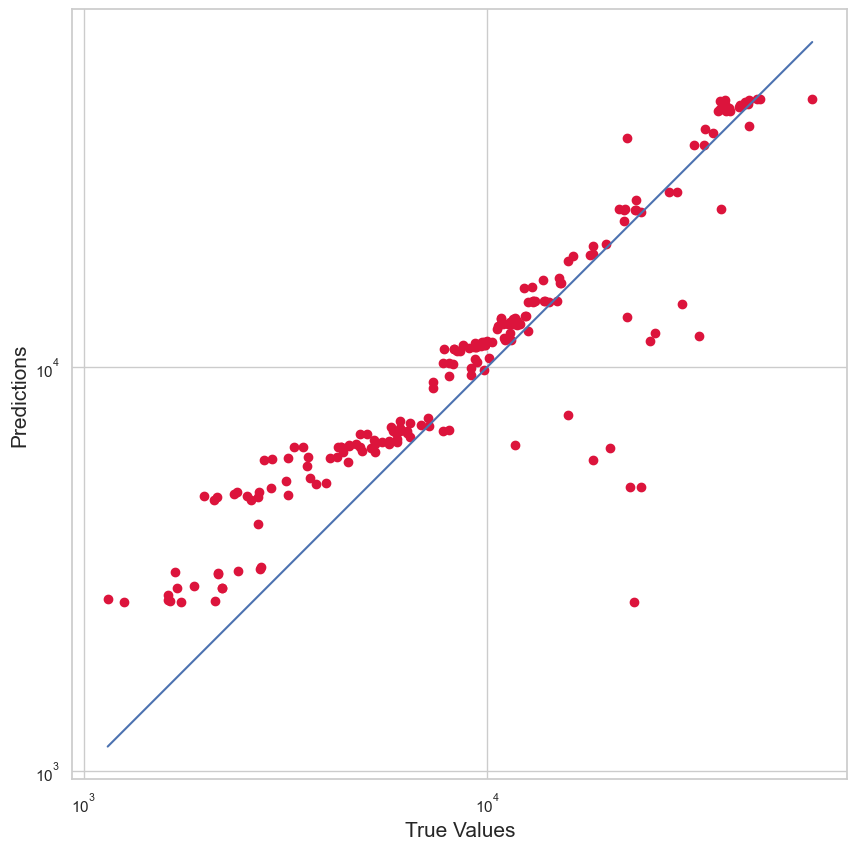

In [71]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

<h2>Ensemble Decision Tree Bagging</h2>

In [75]:
from sklearn.ensemble import BaggingRegressor, _bagging
print(_bagging.MAX_INT)

2147483647


In [78]:
from sklearn.svm import SVR

def bagging_objective(trial):
    params ={
        'max_samples': trial.suggest_int("max_samples", 5, 10),
        'max_features': trial.suggest_int('max_features', 3, 10),
        'n_estimators': trial.suggest_int('n_estimators', 3, 10),
    }

    clf=BaggingRegressor(**params, random_state=42, oob_score = True)
    clf.fit(X_train, y_train)

    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error')

    #pred = clf.predict(X_val)
    #mse = mean_squared_error(y_val, pred)
    return -scores.mean()

In [79]:
study = optuna.create_study(direction="minimize")
study.optimize(bagging_objective, n_trials=100)

[I 2025-11-18 15:14:38,457] A new study created in memory with name: no-name-3477e8b9-5404-4ea8-b4a8-55172d646370
[I 2025-11-18 15:14:38,598] Trial 0 finished with value: 5469.011068378553 and parameters: {'max_samples': 10, 'max_features': 9, 'n_estimators': 5}. Best is trial 0 with value: 5469.011068378553.
[I 2025-11-18 15:14:38,703] Trial 1 finished with value: 7049.562773197203 and parameters: {'max_samples': 5, 'max_features': 3, 'n_estimators': 4}. Best is trial 0 with value: 5469.011068378553.
[I 2025-11-18 15:14:38,834] Trial 2 finished with value: 6786.529831568432 and parameters: {'max_samples': 8, 'max_features': 3, 'n_estimators': 4}. Best is trial 0 with value: 5469.011068378553.
[I 2025-11-18 15:14:38,955] Trial 3 finished with value: 7356.659855422664 and parameters: {'max_samples': 5, 'max_features': 5, 'n_estimators': 4}. Best is trial 0 with value: 5469.011068378553.
[I 2025-11-18 15:14:39,138] Trial 4 finished with value: 6798.402827204902 and parameters: {'max_samp

In [80]:
best_model = BaggingRegressor(**study.best_params, random_state=42)

best_model.fit(X_train, y_train)

def DTtest(best_model):
    test_pred = best_model.predict(X_test)
    test_mse = mean_squared_error(y_test, test_pred)
    test_mae = mean_absolute_error(y_test, test_pred)
    test_r2 = r2_score(y_test, test_pred)
    test_mape = mean_absolute_percentage_error(y_test, test_pred)

    print("Test MSE:", test_mse)
    print("Test MAE:", test_mae)
    print("Test R2:", test_r2)
    print("Test MAPE:", test_mape)

    return [test_mse, test_mae, test_mape, test_r2]

DTtest(best_model=best_model)

Test MSE: 59636285.014948696
Test MAE: 5895.917975338308
Test R2: 0.6067483768843729
Test MAPE: 0.8305405502067629


[59636285.014948696, 5895.917975338308, 0.8305405502067629, 0.6067483768843729]

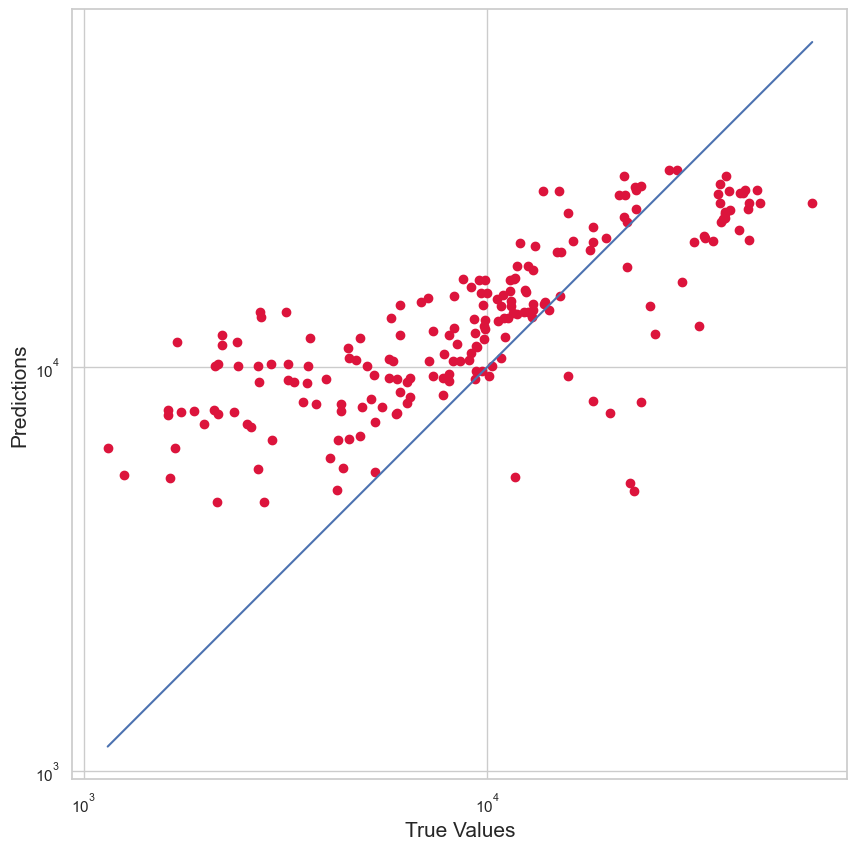

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

In [ ]:
optuna.visualization.plot_optimization_history(study)
optuna.visualization.plot_param_importances(study)

<h2>XGBoost Regressor</h2>

In [82]:
import xgboost

In [83]:
xgb_model = xgboost.XGBRegressor(n_estimators=10, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8, random_state=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, feature_weights=None, gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10, n_jobs=None, ...)

In [84]:
test_pred = xgb_model.predict(X_test)
test_mse = mean_squared_error(y_test, test_pred)
test_mae = mean_absolute_error(y_test, test_pred)
test_mape = mean_absolute_percentage_error(y_test, test_pred)
test_r2 = r2_score(y_test, test_pred)

print("Test MSE:", test_mse)
print("Test MAE:", test_mae)
print("Test MAPE:", test_mape)
print("Test R2:", test_r2)

Test MSE: 37319750.12723554
Test MAE: 4416.560918967662
Test MAPE: 0.7092510744505648
Test R2: 0.7539073349702075


In [ ]:
def xgb_objective(trial):
    params ={
        'n_estimators': trial.suggest_int("n_estimators", 100, 500, log=True),
        'max_depth': trial.suggest_int("max_depth", 2, 10),
        'eta': trial.suggest_float("eta", 0.1, 0.99),
        'subsample':  trial.suggest_float('subsample', 0.2, 0.99),
        'colsample_bytree':  trial.suggest_float('colsample_bytree', 0.1, 0.99),
        'gamma': trial.suggest_float('gamma', 0.1, 0.99),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 0.99),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 0.99),
        #'booster': trial.suggest_categorical('booster', ['dart', 'linear'])

    }
    clf = xgboost.XGBRegressor(**params, random_state=42, n_jobs=8)
    clf.fit(X_train, y_train)

    pred = clf.predict(X_val)
    mse = mean_squared_error(y_val, pred)
    return mse

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(xgb_objective, n_trials=500)

[I 2025-11-18 14:52:16,478] A new study created in memory with name: no-name-29db2ee1-d0e7-421b-bec4-3064d61c6701
[I 2025-11-18 14:52:17,048] Trial 0 finished with value: 27674140.85489427 and parameters: {'n_estimators': 287, 'max_depth': 3, 'eta': 0.3432263029740882, 'subsample': 0.9475011640926698, 'colsample_bytree': 0.4691411721943829, 'gamma': 0.36037878683769764, 'reg_alpha': 0.929826028206527, 'reg_lambda': 0.8037914595624152}. Best is trial 0 with value: 27674140.85489427.
[I 2025-11-18 14:52:17,882] Trial 1 finished with value: 98219499.41938464 and parameters: {'n_estimators': 245, 'max_depth': 6, 'eta': 0.6138051772297377, 'subsample': 0.316399999189081, 'colsample_bytree': 0.8553761230791014, 'gamma': 0.39445613753957487, 'reg_alpha': 0.5212062180104077, 'reg_lambda': 0.2744385708489849}. Best is trial 0 with value: 27674140.85489427.
[I 2025-11-18 14:52:18,069] Trial 2 finished with value: 23160231.00622677 and parameters: {'n_estimators': 106, 'max_depth': 2, 'eta': 0.49

In [ ]:
optuna.visualization.plot_optimization_history(study)
optuna.visualization.plot_param_importances(study)

In [ ]:
best_xgb_model = xgboost.XGBRegressor(**study.best_params, random_state=42)

In [ ]:
plot_importance(xgb_model)
plt.show()

NameError: name 'plot_importance' is not defined

In [ ]:
import joblib

joblib.dump(best_xgb_model, "xgb1.joblib.dat")


['xgb1.joblib.dat']

In [ ]:
loaded_model = joblib.load("xgb1.joblib.dat")

best_xgb_model.fit(X_train, y_train)
test_pred = best_xgb_model.predict(X_test)

def XGBtest(best_model):
    test_pred = best_model.predict(X_test)
    test_mse = mean_squared_error(y_test, test_pred)
    test_mae = mean_absolute_error(y_test, test_pred)
    test_r2 = r2_score(y_test, test_pred)
    test_mape = mean_absolute_percentage_error(y_test, test_pred)

    print("Test MSE:", test_mse)
    print("Test MAE:", test_mae)
    print("Test R2:", test_r2)
    print("Test MAPE:", test_mape)

    return [test_mse, test_mae, test_mape, test_r2]

XGBtest(best_model=best_xgb_model)

Test MSE: 19363532.902726416
Test MAE: 2418.5840742935716
Test R2: 0.8723136301776465
Test MAPE: 0.2690776947826751


[19363532.902726416,
 2418.5840742935716,
 0.2690776947826751,
 0.8723136301776465]

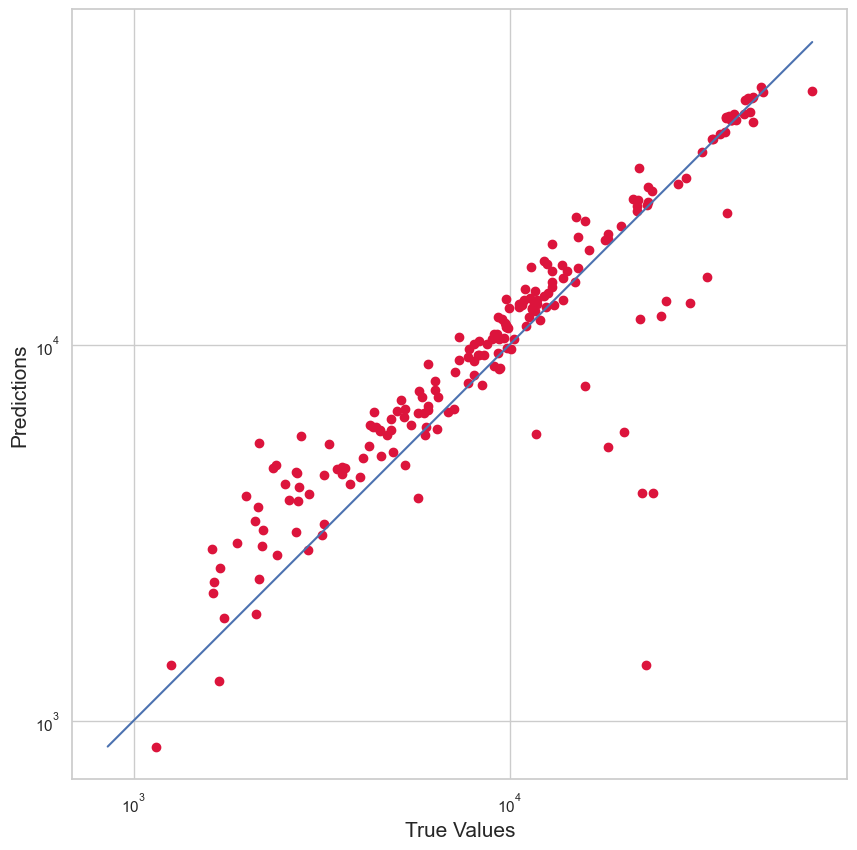

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, test_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(test_pred), max(y_test))
p2 = min(min(test_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

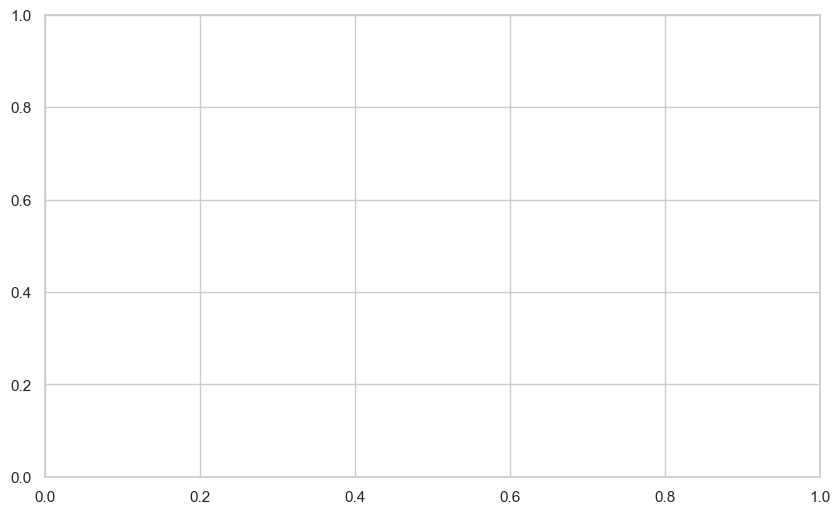

In [39]:
import graphviz

tree_index = 0
xgboost.plot_tree(best_xgb_model, num_trees=tree_index)
plt.show()